FASE I (A Priori) in corso...
σ_atm calcolata (da un CALL K=6835): 14.68%

--- Capitolo 4.2: Tabella Risultati Prezzi CRR ---
Calcoli basati su σ costante = 14.6828%
Strike (K) | Tipo  | Mercato (Mid)   | Prezzo CRR      | Errore (CRR - Mercato)
--------------------------------------------------------------------------------
6815       | call  | 178.60          | 176.83          | -1.77               
6825       | call  | 171.95          | 171.18          | -0.77               
6835       | call  | 165.95          | 165.63          | -0.32               
6845       | call  | 159.45          | 160.77          | 1.32                
6855       | call  | 153.30          | 155.91          | 2.61                
6865       | call  | 147.70          | 151.05          | 3.35                
--------------------------------------------------------------------------------
FASE I (A Priori) completata.
--------------------------------------------------------------------------------

FASE II (Ott

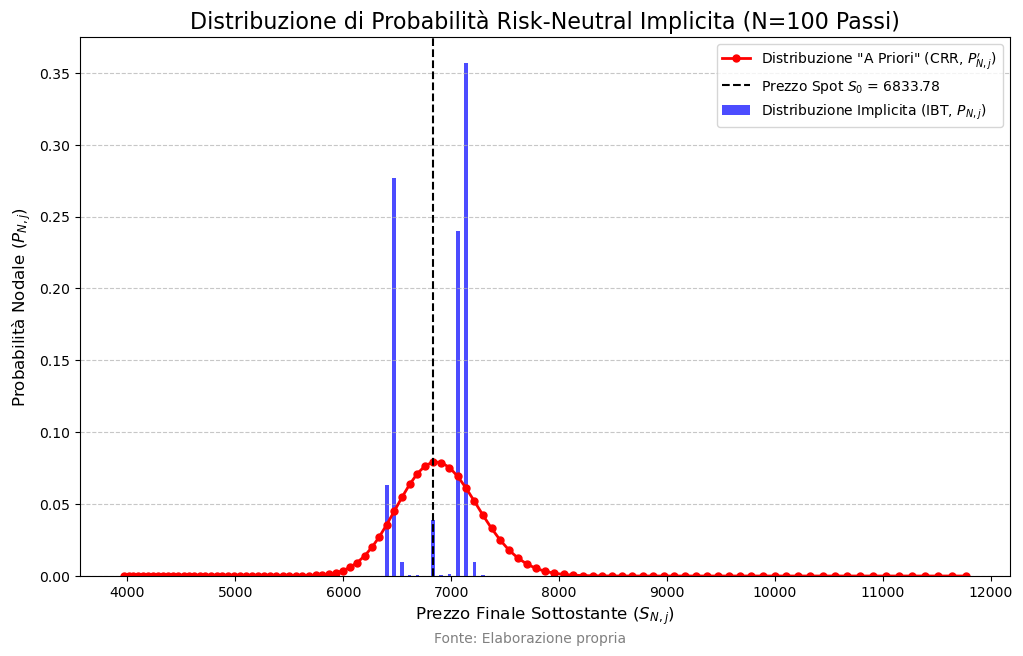

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, minimize
import math
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================================
# SEZIONE 1: FUNZIONI DI PRICING E STRUMENTI
# ==============================================================================

def bs_call_price(sigma, S, K, T, r):
    """Calcola il prezzo di una Call Black-Scholes."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))

def bs_put_price(sigma, S, K, T, r):
    """Calcola il prezzo di un Put Black-Scholes."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))

def implied_volatility(market_price, S, K, T, r, option_type='call'):
    """Trova la volatilità implicita usando Black-Scholes per Call o Put."""
    
    if option_type.lower() == 'call':
        pricer_func = bs_call_price
    elif option_type.lower() == 'put':
        pricer_func = bs_put_price
    else:
        raise ValueError("option_type deve essere 'call' o 'put'")

    def objective_func(sigma):
        return pricer_func(sigma, S, K, T, r) - market_price
        
    try:
        # Intervallo standard [0.01, 3.0]
        iv = brentq(objective_func, 0.01, 3.0) 
    except ValueError:
        iv = np.nan
    return iv

def crr_price(S0, K, T, r, sigma, N, option_type='call'):
    """Calcola il prezzo di una opzione CRR (con sigma costante)."""
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    m = np.exp(r * dt)
    q = (m - d) / (u - d)
    
    if not (d < m < u):
        return np.nan 

    S_T = np.zeros(N + 1)
    for j in range(N + 1):
        S_T[j] = S0 * (u**j) * (d**(N - j))
    
    if option_type.lower() == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    
    # Backward Induction
    for t in range(N - 1, -1, -1):
        for j in range(t + 1):
            payoffs[j] = (q * payoffs[j + 1] + (1 - q) * payoffs[j]) / m
            
    return payoffs[0]

# ==============================================================================
# SEZIONE 2: FUNZIONE OBIETTIVO PER OTTIMIZZAZIONE IBT (Necessita di S_Nj e dati esterni)
# ==============================================================================

# Questa funzione sarà definita nel blocco principale per accedere ai dati di input.

# ==============================================================================
# SEZIONE 3: DATI E ESECUZIONE PRINCIPALE
# ==============================================================================
if __name__ == "__main__":

    # --- 2. Dati di Input (dall'utente) ---
    S0 = 6833.78
    r = 0.038854
    T = 50 / 365.0
    N = 100 
    dt = T / N

    strikes = [6815, 6825, 6835, 6845, 6855, 6865]
    bids = [178.2, 171.6, 165.6, 159.1, 153, 147.4]
    asks = [179, 172.3, 166.3, 159.8, 153.6, 148]
    market_prices_mid = [(b + a) / 2 for b, a in zip(bids, asks)]
    option_types = ['call', 'call', 'call', 'call', 'call', 'call']

    # --- Dati Sensibili: Soluzione di Excel per initial_guess ---
    excel_probabilities_descending = [
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00013257, 0.01157300, 
        0.02435379, 0.03836332, 0.05327699, 0.06854713, 0.08343786, 0.09711016, 
        0.10874213, 0.11766500, 0.06656339, 0.06432034, 0.05927992, 0.05204519, 
        0.04340839, 0.03421681, 0.02524507, 0.01709950, 0.01016895, 0.00462274, 
        0.00044540, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 
        0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.00019965, 
        0.00046640, 0.00073027, 0.00099129, 0.00124949, 0.00150489, 0.00175754, 
        0.00200745, 0.00225466, 0.00249920, 0.00274109, 0.00298036
    ]

    # --- FASE I: CALCOLO PARAMETRI CRR "A PRIORI" ---
    print("FASE I (A Priori) in corso...")
    atm_strike = 6835
    atm_price = (165.6 + 166.3) / 2
    atm_type = 'call' 
    sigma_atm = implied_volatility(atm_price, S0, atm_strike, T, r, atm_type)

    u = np.exp(sigma_atm * np.sqrt(dt))
    d = 1.0 / u
    m = np.exp(r * dt) 
    q = (m - d) / (u - d)

    S_Nj = np.zeros(N + 1)
    for j in range(N + 1):
        S_Nj[j] = S0 * (u**j) * (d**(N - j))
    
    # P_Nj_prime (Probabilità A Priori CRR)
    P_Nj_prime = np.zeros(N + 1)
    for j in range(N + 1):
        binom_coeff = math.comb(N, j)
        P_Nj_prime[j] = binom_coeff * (q**j) * ((1 - q)**(N - j))
    
    # Preparazione initial_guess da Excel (inversione e normalizzazione)
    initial_guess_array = np.array(excel_probabilities_descending)
    initial_guess = initial_guess_array[::-1] / np.sum(initial_guess_array)
    
    print(f"σ_atm calcolata (da un CALL K={atm_strike}): {sigma_atm*100:.2f}%")

    # [STAMPA TABELLA CRR]
    print("\n--- Capitolo 4.2: Tabella Risultati Prezzi CRR ---")
    print(f"Calcoli basati su σ costante = {sigma_atm*100:.4f}%")
    print("=" * 80)
    print(f"{'Strike (K)':<10} | {'Tipo':<5} | {'Mercato (Mid)':<15} | {'Prezzo CRR':<15} | {'Errore (CRR - Mercato)':<20}")
    print("-" * 80)

    for K, market_price, opt_type in zip(strikes, market_prices_mid, option_types):
        price_crr = crr_price(S0, K, T, r, sigma_atm, N, opt_type)
        error = price_crr - market_price
        print(f"{K:<10} | {opt_type:<5} | {market_price:<15.2f} | {price_crr:<15.2f} | {error:<20.2f}")
    print("-" * 80)
    print("FASE I (A Priori) completata.")
    print("-" * 80)

    # ==========================================================================
    # FASE II: OTTIMIZZAZIONE IBT
    # ==========================================================================
    
    # Definiamo la funzione obiettivo QUI per accedere a tutte le variabili (S0, S_Nj, strikes, etc.)
    def objective_sse(P_Nj):
        S0_implied = (np.sum(P_Nj * S_Nj)) / np.exp(r * T)
        C_implied = np.zeros(len(strikes))
        
        for i, K in enumerate(strikes):
            opt_type = option_types[i]
            if opt_type == 'call':
                payoffs = np.maximum(S_Nj - K, 0)
            else:
                payoffs = np.maximum(K - S_Nj, 0)
                
            C_implied[i] = (np.sum(P_Nj * payoffs)) / np.exp(r * T)
        
        # Calcola errore SSE
        s0_error = (S0_implied - S0)**2
        c_errors = np.sum((C_implied - market_prices_mid)**2)
        
        return s0_error + c_errors

    print("\nFASE II (Ottimizzazione IBT) in corso...")
    
    # Vincoli (Somma=1 e Pj >= 0)
    constraints = [
        {'type': 'eq', 'fun': lambda P_Nj: np.sum(P_Nj) - 1.0}
    ]
    bounds = [(0, 1)] * (N + 1)

    # Esegui l'ottimizzazione (Solver)
    result = minimize(objective_sse, 
                      initial_guess,
                      method='SLSQP',
                      constraints=constraints,
                      bounds=bounds,
                      options={'ftol': 1e-10, 'maxiter': 5000}) 

    P_Nj_implied = result.x
    print(f"Ottimizzazione completata. Errore finale: {result.fun:.6f}")

    # ==========================================================================
    # FASE 5: ANALISI E VERIFICA
    # ==========================================================================

    # 5.1 Tabella Confronto Probabilità 
    print("\n--- Capitolo 4.4: Tabella Confronto Probabilità Nodali ---")
    print("=" * 80)
    print(f"{'Nodo (j)':<10} | {'Prezzo Finale (S_Nj)':<20} | {'Prob. Priori (CRR)':<25} | {'Prob. Posteriori (IBT)':<25}")
    print("-" * 80)
    for j in range(N + 1):
        print(f"{j:<10} | {S_Nj[j]:<20.4f} | {P_Nj_prime[j]:<25.10f} | {P_Nj_implied[j]:<25.10f}")
    print("-" * 80)
    print(f"{'Somma':<10} | {'-':<20} | {np.sum(P_Nj_prime):<25.6f} | {np.sum(P_Nj_implied):<25.6f}")

    # --- TABELLA DI VERIFICA CONDIZIONI ---
    print("\n" + "="*90)
    print(" TABELLA DI VERIFICA DELLE CONDIZIONI (Validazione Modello)")
    print("="*90)

    # Verifica 1: Somma Probabilità
    prob_sum = np.sum(P_Nj_implied)
    print(f"1. SOMMA PROBABILITÀ = 1:\n   - Valore calcolato: {prob_sum:.10f}\n   - Esito: {'[OK]' if abs(prob_sum - 1.0) < 1e-5 else '[FAIL]'}")

    # Verifica 2: Prezzo Spot
    S0_implied_check = (np.sum(P_Nj_implied * S_Nj)) / np.exp(r * T)
    spot_diff = S0_implied_check - S0
    print(f"\n2. REPLICA PREZZO SPOT (S0 = {S0:.2f}):\n   - S0 Implicito:     {S0_implied_check:.4f}\n   - Differenza:       {spot_diff:.6f}\n   - Esito:            {'[OK]' if abs(spot_diff) < 0.1 else '[WARNING]'}")

    # Verifica 3: No-Arbitraggio (Bid-Ask Spread)
    print(f"\n3. CONDIZIONE NO-ARBITRAGGIO (Prezzi IBT vs Bid-Ask Spread):")
    print("-" * 90)
    print(f"   {'Strike':<8} | {'Tipo':<5} | {'Bid':<8} | {'Prezzo IBT':<10} | {'Ask':<8} | {'Status':<10} | {'Check'}")
    print("-" * 90)

    C_final = np.zeros(len(strikes))
    all_ok = True

    for i, K in enumerate(strikes):
        if option_types[i] == 'call':
            payoffs = np.maximum(S_Nj - K, 0)
        else:
            payoffs = np.maximum(K - S_Nj, 0)
        
        p_ibt = (np.sum(P_Nj_implied * payoffs)) / np.exp(r * T)
        C_final[i] = p_ibt
        
        bid = bids[i]
        ask = asks[i]
        
        in_spread = (p_ibt >= bid) and (p_ibt <= ask)
        status = "DENTRO" if in_spread else "FUORI"
        check = "[OK]" if in_spread else "[ARB!]"
        if not in_spread: all_ok = False
        
        print(f"   {K:<8} | {option_types[i]:<5} | {bid:<8.2f} | {p_ibt:<10.2f} | {ask:<8.2f} | {status:<10} | {check}")

    print("-" * 90)
    if all_ok:
        print("   >>> RISULTATO GLOBALE: Il modello rispetta tutti gli spread Bid-Ask. Nessun arbitraggio.")
    else:
        print("   >>> RISULTATO GLOBALE: Attenzione, alcuni prezzi sono fuori dallo spread.")
    print("=" * 90)

    # 5.3. Grafico
    print("\nGenerazione grafico...")
    plt.figure(figsize=(12, 7))
    width = (S_Nj[1] - S_Nj[0]) * 0.8
    plt.bar(S_Nj, P_Nj_implied, width=width, label='Distribuzione Implicita (IBT, $P_{N,j}$)', color='blue', alpha=0.7)
    plt.plot(S_Nj, P_Nj_prime, 'ro-', label='Distribuzione "A Priori" (CRR, $P_{N,j}\'$)', linewidth=2, markersize=5)
    plt.title(f'Distribuzione di Probabilità Risk-Neutral Implicita (N={N} Passi)', fontsize=16)
    plt.xlabel('Prezzo Finale Sottostante ($S_{N,j}$)', fontsize=12)
    plt.ylabel('Probabilità Nodale ($P_{N,j}$)', fontsize=12)
    plt.axvline(S0, color='black', linestyle='--', label=f'Prezzo Spot $S_0$ = {S0:.2f}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.figtext(0.5, 0.01, 'Fonte: Elaborazione propria', ha='center', va='bottom', fontsize=10, color='gray')
    plt.savefig('distribuzione_probabilita_IBT_finale.png', bbox_inches='tight')
    print("Grafico salvato.")